<a href="https://colab.research.google.com/github/DaveMSU/msu_ml_spring_2020/blob/master/01/harazyan_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [0]:
import warnings # Чтобы избежать лишних предупреждений, конкретно при подсчете tfidf, игнорировать предупреждения о делении на 0
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree # 2-ой import для 3-его задания
from sklearn.metrics import accuracy_score

from scipy.spatial.distance import cdist        # Для попарных расстояний (в итоге полностью использовал pairwise_distances)
import re                                       # Для описания регулярных выражений
from scipy.sparse import csr_matrix, lil_matrix # Для хранения разряженных матриц
from scipy.sparse import vstack as sp_vstack    # Для реализации cross_val_score функции
from collections  import defaultdict as ddict   # Для того, чтобы постояно не инициализировать стандартный dict() нулем
from sklearn.metrics import pairwise_distances as csr_cdist # Чтобы считать расстояния для случая когда матрицы сжатого формата

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [0]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, metric='euclidean', algorithm='brute'):
        
        assert(algorithm in ['brute', 'kd_tree'])
        self.metric = metric
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
        self.y_prob = np.array([[]])
        self.y_pred = np.array([])
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.asarray(y)
        self.number_labels = np.unique(self.y_train).shape[0]
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=40)

    def predict(self, X):
        
        self.y_pred = np.empty(X.shape[0])
        self.y_prob = np.empty((X.shape[0], self.number_labels))
        
        labels = np.tile(self.y_train, X.shape[0]).reshape(X.shape[0], self.y_train.shape[0])
        if self.algorithm == 'brute':
            tmp = np.argpartition(csr_cdist(X, self.X_train, metric=self.metric), kth=self.n_neighbors, axis=1) # cdist не работает с разряженными матрицами.
        elif self.algorithm == 'kd_tree': # Не работает с csr_matrix, KNN из sklearn, так же не поддерживает.
            tmp = self.tree.query(X, k=self.n_neighbors, return_distance =False)
        
        def raz_index(arr):
            return arr[:self.X_train.shape[0]][arr[self.X_train.shape[0]:]]
        
        labels = np.apply_along_axis(raz_index, 1, np.hstack((labels, tmp)))[:,:self.n_neighbors]
        tmp = np.apply_along_axis(np.bincount, 1, labels, minlength = self.number_labels)
        
        self.y_prob = np.divide(tmp.T, np.sum(tmp, axis=1)).T
        self.y_pred = np.argmax(self.y_prob, axis=1)
        
        return self.y_pred.copy()

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [0]:
iris = datasets.load_iris()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [0]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [0]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [0]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 1.31 ms, sys: 68 µs, total: 1.38 ms
Wall time: 2.21 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 380 µs, sys: 85 µs, total: 465 µs
Wall time: 601 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 2.18 ms, sys: 40 µs, total: 2.22 ms
Wall time: 2.48 ms


array([2, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 1, 0, 1, 0])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 935 µs, sys: 764 µs, total: 1.7 ms
Wall time: 3.19 ms


array([2, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 1, 0, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [0]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 10.4 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 418 µs, sys: 0 ns, total: 418 µs
Wall time: 534 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 1.96 ms, sys: 1.78 ms, total: 3.74 ms
Wall time: 2.98 ms


array([0, 0, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 0, 1, 2])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 1.62 ms, sys: 137 µs, total: 1.76 ms
Wall time: 1.22 ms


array([0, 0, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 0, 1, 2])

In [0]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [0]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
TOKEN_RE = re.compile(r'[\w\d]+')

def tokenize_sentence(txt, min_token_size=3):
    tokens = TOKEN_RE.findall(txt.lower())
    return [token for token in tokens if len(token) >= min_token_size]

def tokinize_corpus(corpus, 
                    target,
                    min_doc_size = 1, 
                    min_token_size = 3,
                    tokenizer=tokenize_sentence):
  
    data_tokenized = [token for token in [tokenizer(line, min_token_size) for line in corpus] if len(token) >= min_doc_size]
    new_labels = [target[i] for i in range(len(corpus)) if len(tokenizer(corpus[i], min_token_size)) >= min_doc_size]
    return data_tokenized, new_labels

doc_size = 1   # Minimum of Document Size
token_size = 4 # Minimum of Token Size
data_tok, labels = tokinize_corpus(data,
                                   target,
                                   min_doc_size=doc_size,
                                   min_token_size=token_size)

print('Токенизация и фильтрация корпуса по минимальным длине слова и документа:')
print('Кол-во текстов в выборке:', len(data_tok)) # Должны совпадать
print('Кол-во меток:', len(labels)) # Должны совпадать

Токенизация и фильтрация корпуса по минимальным длине слова и документа:
Кол-во текстов в выборке: 10995
Кол-во меток: 10995


In [23]:
def build_vocabilary(texts, min_word_count=5, max_word_freq=0.8, max_size=-1):
    word_counts = ddict(int)
    corpus_len = len(texts)

    # Считаем кол-во встречаемости слова в корпусе и ков-во документов в нем
    for text in texts:
        unique_tokens = set(text)
        for token in unique_tokens:
            word_counts[token] += 1

    # Убираем слишком частные и слишком редкие слова (вспомним расспределение Ципфа)
    word_counts = {word: cnt for word, cnt in word_counts.items()\
                  if cnt >= min_word_count and cnt / corpus_len <= max_word_freq}

    # Сортируем слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])[:max_size]
  
    # Нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # Нормируем слова (частота слова в корпусе)
    word2freq = np.array( [word_count/corpus_len for _, word_count in sorted_word_counts], dtype='float32') # В дальнейшем будет использовать для построения TFIDF

    return word2id, word2freq

word_count = 3  # Порог снизу на кол-во появления слова во всем корпусе (чтобы убирать очень редко употребимые слова - двадцатибуквенный, превет, ...)
word_freq = 0.8 # Порог сверху на долю текстов, в которых слово встречалось (чтобы убирать слишком часто употрибимые слова - у, в, над, и, ...)
doc_size = -1   # Порог на кол-во возможных слов в корпусе (в силу построения словаря, срез происходит отсечением более редких слов, т.е. отбрасыванием хвоста словаря)

# Словарь - мн-во пар вида (токен, id), где токен с меньшим id, встречается чаще, чем с большим
vocabulary, word_doc_freq = build_vocabilary(data_tok,
                                        word_count,
                                        word_freq,
                                        doc_size)

print('Мощность используемой лексики: ', len(vocabulary))

Мощность используемой лексики:  22350


In [24]:
print("5 самых частых слов: ", list(vocabulary.keys())[:10])
print("5 самых редких слов: ", list(vocabulary.keys())[-5:])

5 самых частых слов:  ['that', 'this', 'have', 'with', 'from', 'they', 'there', 'would', 'what', 'about']
5 самых редких слов:  ['punk', 'oftentimes', 'contraband', 'swamping', 'hunch']


In [25]:
def vectorize_text(tokenized_corpus,
                   word2id, word2freq,
                   mode='count',
                   scale=False):

    assert(mode in ['count', 'bin', 'tfidf']) # Вообще говоря, можно добавить вполне просто mode'ы такие как -
                                              # - 'tf', 'idf', 'ltfidf', но чтобы не загромождать и так большой код включать их сюда не будем.

    result = lil_matrix((len(tokenized_corpus), len(word2id)), dtype='float32')
  
    for text_id, text in enumerate(tokenized_corpus):
        for token in text:
            if token in word2id:
                result[text_id, word2id[token]] += 1
  
    if mode == 'bin':
        result = (result > 0).astype('float32')
  
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(axis=1)) # Частоты слов в документе (tf)
        result = result.multiply(1 / word2freq)          # Обратные частоты слов в корпусе (idf) 

    if scale:
        result = result.tocsc()
        result -= result.min() # Стандартизируем, т.к. нормализация не подходит -
        result /= result.max() + 1e-6 # - в силу того, что матрица перестанет быть разреженной.
  
    return result.tocsr() # csr - лучше подходит для работы со строками

matrix = vectorize_text(data_tok, vocabulary, word_doc_freq)
print('Размер матрицы признаков (документ, слово):', matrix.shape)

Размер матрицы признаков (документ, слово): (10995, 22350)


In [28]:
# Ну или можно и так
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
matrix_from_box = vectorizer.fit_transform(data)
print('Размер матрицы признаков (документ, слово):', matrix_from_box.shape)

Размер матрицы признаков (документ, слово): (11314, 101631)


*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [0]:
def K_fold(data, target, K_fold = 3, seed=2357): # Получаем tuple(пару), в каждом из которых K_fold np.array'ев - объекты и соотв-ие им метки.
    np.random.seed(seed)
    data_size = data.shape[0] // K_fold
    rows = np.random.permutation(np.arange(data_size * K_fold))
    indexes = [rows[fold*data_size:(fold+1)*data_size].tolist() for fold in range(K_fold)]
    return np.array([data[indx] for indx in indexes]), np.array([np.asarray(target)[indx] for indx in indexes])

In [0]:
def cross_val_score(objects, targets, model, metric, num_fold=3, seed=2357):
    X, y = K_fold(objects, targets, K_fold=num_fold, seed=seed)
    score_history = []

    for i in range(num_fold):
        train_index = [indx for indx in range(0,i)] + [indx for indx in range(i+1,num_fold)]

        X_train = X[train_index[0]]
        y_train = y[train_index[0]]
      
        for index in train_index[1:]:
            X_train = sp_vstack((X_train,X[index]))
            y_train = np.hstack((y_train,y[index]))

        X_val, y_val = X[i], y[i]
        model.fit(X_train, y_train)
        score = metric(model.predict(X_val), y_val)
        score_history.append(score)
    return score_history

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [31]:
num_fold = 3
all_score_history = []
for k_neighbors in range(1,40):
    
    my_clf = MyKNeighborsClassifier(n_neighbors=k_neighbors, algorithm='brute')
    score_history = cross_val_score(matrix, labels, my_clf, accuracy_score, num_fold)
    all_score_history.append(np.mean(score_history))

    if (k_neighbors-1) % 5 == 0:
        print('kn =', k_neighbors, ", mean_score: %.4f" % all_score_history[-1])

kn = 1 , mean_score: 0.2364
kn = 6 , mean_score: 0.1983
kn = 11 , mean_score: 0.1954
kn = 16 , mean_score: 0.1919
kn = 21 , mean_score: 0.1917
kn = 26 , mean_score: 0.1880
kn = 31 , mean_score: 0.1875
kn = 36 , mean_score: 0.1866


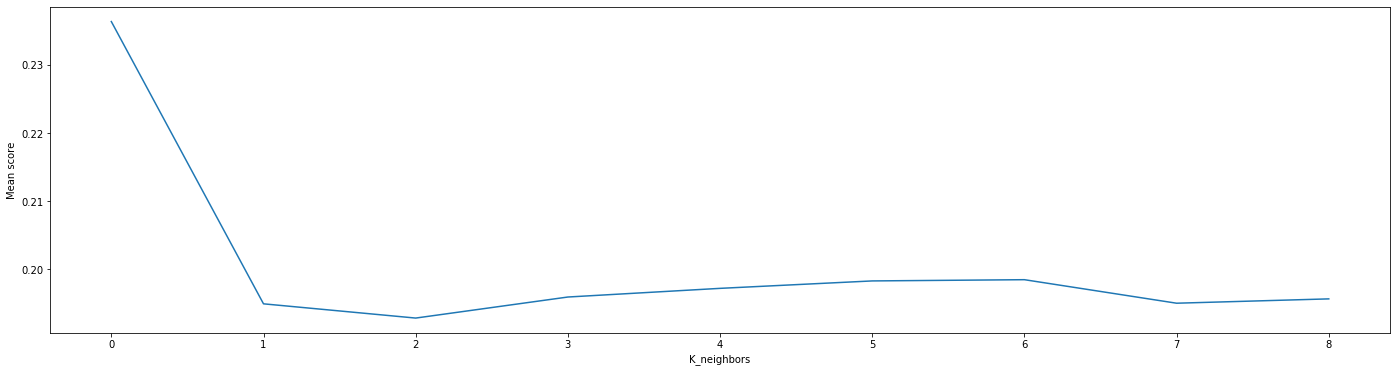

In [0]:
# Рисуем график loss-функции от k_neighbors

fig = plt.figure(figsize= (24,6))
ax=fig.add_subplot(111)
ax.set_xlabel('K_neighbors')
ax.set_ylabel('Mean score')
plt.plot(all_score_history);

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [33]:
# Постараемся еще сильнее уменьшить влияние переобучения 
#  (увеличим кол-во итераций для подсчета score до 15)
#  (поменяем способ высчитывания среднего score)

matrix = vectorize_text(data_tok, vocabulary, word_doc_freq, mode='tfidf')
num_fold = 3
all_score_history = []

for k_neighbors in range(1,200,10):
    
    my_clf = MyKNeighborsClassifier(n_neighbors=k_neighbors, metric='cosine', algorithm='brute')

    score_history = []
    for seed in [2357,2375,2537,2573,2735]:
        score_history += cross_val_score(objects = matrix,
                                         targets = labels,
                                         model = my_clf,
                                         metric = accuracy_score,
                                         num_fold = num_fold,
                                         seed = seed)
      
    all_score_history.append(np.mean(sorted(score_history)[3:-3])) # Считаем среднее между квантилями, чтобы избежать влияние выбросов.

    print('kn =', k_neighbors, ", mean_score: %.4f" % all_score_history[-1])

kn = 1 , mean_score: 0.4864
kn = 11 , mean_score: 0.6101
kn = 21 , mean_score: 0.6478
kn = 31 , mean_score: 0.6593
kn = 41 , mean_score: 0.6640
kn = 51 , mean_score: 0.6662
kn = 61 , mean_score: 0.6673
kn = 71 , mean_score: 0.6685
kn = 81 , mean_score: 0.6684
kn = 91 , mean_score: 0.6682
kn = 101 , mean_score: 0.6687
kn = 111 , mean_score: 0.6700
kn = 121 , mean_score: 0.6677
kn = 131 , mean_score: 0.6682
kn = 141 , mean_score: 0.6660
kn = 151 , mean_score: 0.6646
kn = 161 , mean_score: 0.6638
kn = 171 , mean_score: 0.6637
kn = 181 , mean_score: 0.6620
kn = 191 , mean_score: 0.6613


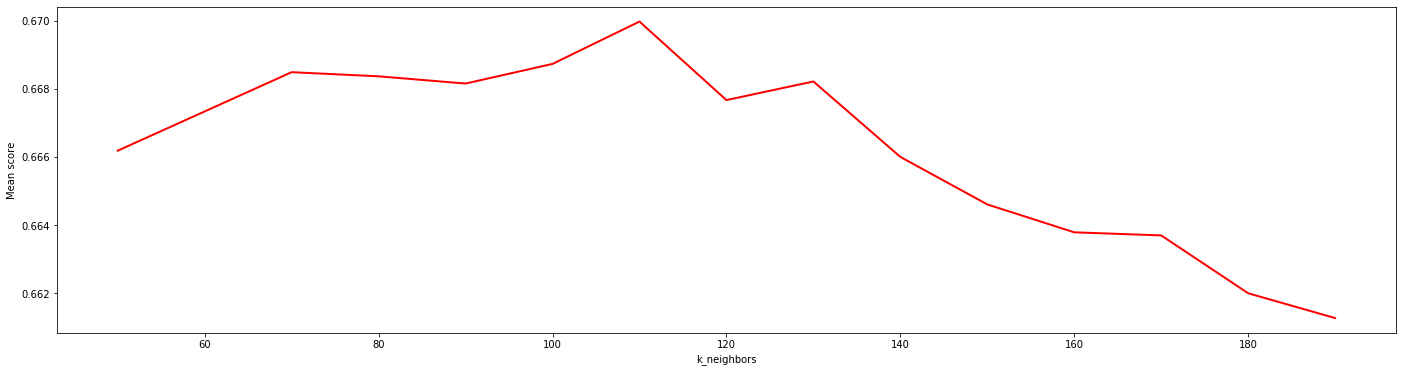

In [43]:
# Давайте лишний раз посмотреть на график

fig = plt.figure(figsize= (24,6))
ax=fig.add_subplot(111)
x_scope = [i*10 for i in range(len(all_score_history))]
ax.plot(x_scope[5:], all_score_history[5:], color = 'r', linewidth = 2)
ax.set_ylabel('Mean score')
ax.set_xlabel('k_neighbors');

In [0]:
# Лучший результат score = 0.67, kn = 110.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [0]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

test_data = newsgroups['data']
test_target = newsgroups['target']

data_tok, test_labels = tokinize_corpus(test_data,
                                        test_target,
                                        min_doc_size=doc_size,
                                        min_token_size=token_size)
test_matrix = vectorize_text(data_tok,
                             vocabulary,
                             word_doc_freq,
                             mode='tfidf') # Vocabulary, word_doc_freq  беруться из трейна, -
                                           #  - т.к. они не известны на тесте.

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [0]:
data_tok, train_labels = tokinize_corpus(data, target, min_doc_size=doc_size, min_token_size=token_size) 
vocabulary, word_doc_freq = build_vocabilary(data_tok, word_count, word_freq, doc_size)
train_matrix = vectorize_text(data_tok, vocabulary, word_doc_freq, mode='tfidf')

In [0]:
my_clf = MyKNeighborsClassifier(n_neighbors=110, metric='cosine', algorithm='brute')
my_clf.fit(train_matrix, train_labels)

In [47]:
print('Final(test) score: %.4f - (Accuaracy)' % accuracy_score(my_clf.predict(test_matrix), test_labels))

Final(test) score: 0.6317 - (Accuaracy)


Вывод: Качество на тесте уступает качеству на кросс валидации, вообще говоря это далеко не тривиальный вопрос, но можно с уверенностью сказать, что мы не избавились полностью от переобучения даже используя хитрые способы подсчета статистик (ошибки), т.к. мы не строили каждый раз новый словарь (vocabulary и word_doc_freq) и знали зарания параметры tfidf, чего не знали при тесте.
